# VE472 Lab 7 - Analysis on a real dataset

In this lab, we explore ways of applying big data tools (such as Spark) and data analysis algorithms (such as PCA and Gradient Descent) on a real dataset.

## Start a spark session



In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Cell Categorizing").getOrCreate()
sc = SparkContext.getOrCreate()

## Import Data

We use a pre-processed table from the [PBME single cell gene dataset](https://support.10xgenomics.com/single-cell-gene-expression/datasets). This dataset contains the amount of mRNA each cell is producing. Each cell can do its job using the following steps

1. Produce some mRNA, which are copies of substring of its DNA.
2. The mRNA can then be used to produce certain protein.

We can usually categorize the cells based on the amount of mRNAs they are producing.

In [2]:
import pandas as pd

df = pd.read_csv("datasets/PBMC_16k_RNA.csv")
df

index    KLHL17      HES4     ISG15  TNFRSF18      DVL1  \
0      AAGGTTCTCAGTTTGG-1 -0.062041 -0.285881 -0.560540 -0.127162 -0.079617   
1      CGGACGTAGAAACGCC-1 -0.096750 -0.422268  1.802201 -0.130129 -0.109067   
2      GGCTCGATCCTAAGTG-1 -0.043204 -0.125651 -0.443873 -0.134964 -0.059759   
3      TACACGACAATAGCGG-1 -0.056054 -0.274477  1.503680 -0.125326 -0.075082   
4      TCAATCTCATTCGACA-1 -0.042632 -0.274954 -0.557297 -0.118369 -0.066086   
...                   ...       ...       ...       ...       ...       ...   
15406  ACACCAATCGTTGACA-1 -0.044050 -0.160333 -0.469966 -0.131613 -0.061886   
15407  TCGTAGAAGATGTCGG-1 -0.042985 -0.158367 -0.468752 -0.131279 -0.061082   
15408  ACAGCCGCATGGGAAC-1 -0.050650 -0.093038 -0.417193 -0.142356 -0.063295   
15409  TTCTCAAAGCTACCGC-1 -0.046227 -0.078426 -0.407257 -0.141675 -0.059666   
15410  GATCGCGTCTCTGAGA-1 -0.059452 -0.584799  0.641759 -0.093193 -0.091315   

         FNDC10    MMP23B     MMEL1  AL031848.2  ...  AP000254.1     EVA1C  \
0     -0.093319 -0.140865 -0.060497   -0.055032  ...   -0.078254 -0.075207   
1     -0.158134 -0.183448 -0.057108   -0.016359  ...   -0.099833 -0.035380   
2     -0.054196 -0.139768 -0.048570   -0.075208  ...   -0.052410 -0.098180   
3     -0.082692 -0.130423 -0.063018   -0.061818  ...   -0.076519 -0.081887   
4     -0.060065 -0.100369 -0.072826   -0.077272  ...   -0.076899 -0.096449   
...         ...       ...       ...         ...  ...         ...       ...   
15406 -0.057211 -0.132798 -0.053494   -0.074561  ...   -0.058076 -0.096715   
15407 -0.055323 -0.130924 -0.053953   -0.075769  ...   -0.057778 -0.097903   
15408 -0.065269 -0.164701 -0.037962   -0.066329  ...   -0.046896 -0.090611   
15409 -0.057135 -0.158567 -0.038836   -0.071284  ...   -0.044600 -0.095643   
15410 -0.102631 -0.058762 -0.110109   -0.060828  ...   -0.127316 -0.073309   

          OLIG1    SLC5A3     RCAN1      ETS2  LINC01678    ICOSLG    COL6A2  \
0     -0.161188 -0.270741 -0.143990 -0.251692  -0.125107 -0.091514  5.149085   
1     -0.304415 -0.348583 -0.227306 -0.396200  -0.151201 -0.120818 -0.149679   
2     -0.075017 -0.216184 -0.085765 -0.134578  -0.091013 -0.060557 -0.173621   
3     -0.137666  3.630921 -0.131447 -0.232202  -0.123408 -0.088576 -0.151663   
4     -0.087493 -0.236542 -0.107260 -0.200204  -0.125622 -0.086537 -0.142041   
...         ...       ...       ...       ...        ...       ...       ...   
15406 -0.081577 -0.222559 -0.092528 -0.152172  -0.098899 -0.066747 -0.166980   
15407 -0.077398 -0.220487 -0.090305 -0.148732  -0.098611 -0.066235 -0.166635   
15408 -0.099685 -0.224049 -0.094303 -0.137814  -0.082306 -0.056039 -0.185714   
15409 -0.081703 -0.214524 -0.084103 -0.120641  -0.079620 -0.052788 -0.185627   
15410 -0.180761 -0.309069 -0.184414 -0.379613  -0.194624 -0.143301 -0.089278   

       MCM3AP-AS1  
0       -0.112911  
1       -0.085204  
2       -0.130007  
3       -0.117401  
4       -0.126844  
...           ...  
15406   -0.128583  
15407   -0.129380  
15408   -0.125541  
15409   -0.129006  
15410   -0.107596  

[15411 rows x 1883 columns]

Read the csv into a spark dataframe

In [3]:
spark_df = spark.read.options(header='true', inferSchema='true').csv("datasets/PBMC_16k_RNA.csv")

Some column names contains `.`, which pyspark will report an error while processing. We need to replace that.

In [4]:
transformed_columns = []
for col in spark_df.columns:
    transformed_columns.append(col.strip().replace('.', ''))

spark_df = spark_df.toDF(*transformed_columns)

In [5]:
# Merge the features into one vector
from pyspark.ml.feature import VectorAssembler

feature_cols = spark_df.drop('index').columns
feature_assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
feature_df = feature_assembler.transform(spark_df).select('index', 'features')
feature_df.show(5)

+------------------+--------------------+
|             index|            features|
+------------------+--------------------+
|AAGGTTCTCAGTTTGG-1|[-0.06204129,-0.2...|
|CGGACGTAGAAACGCC-1|[-0.09675046,-0.4...|
|GGCTCGATCCTAAGTG-1|[-0.043204147,-0....|
|TACACGACAATAGCGG-1|[-0.056053527,-0....|
|TCAATCTCATTCGACA-1|[-0.042632394,-0....|
+------------------+--------------------+
only showing top 5 rows



Although this dataset has already been pre-processed, we still need to standardize the feature columns so that each feature contribute to PCA equally.

In [6]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='features', outputCol='standardized_features')
standardized_df = scaler.fit(feature_df).transform(feature_df).select('index', 'standardized_features')
standardized_df.show(5)


+------------------+---------------------+
|             index|standardized_features|
+------------------+---------------------+
|AAGGTTCTCAGTTTGG-1| [-0.1244221378800...|
|CGGACGTAGAAACGCC-1| [-0.1940304444681...|
|GGCTCGATCCTAAGTG-1| [-0.0866447544050...|
|TACACGACAATAGCGG-1| [-0.1124138402837...|
|TCAATCTCATTCGACA-1| [-0.0854981191465...|
+------------------+---------------------+
only showing top 5 rows



## PCA

To visualize our data, we will need to calculate the first two principal components.

In [7]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol='standardized_features', outputCol='pca_features')
pca_model = pca.fit(standardized_df)
pca_df = pca_model.transform(standardized_df)

In [8]:
pca_df.show(5)

+------------------+---------------------+--------------------+
|             index|standardized_features|        pca_features|
+------------------+---------------------+--------------------+
|AAGGTTCTCAGTTTGG-1| [-0.1244221378800...|[7.55190724793356...|
|CGGACGTAGAAACGCC-1| [-0.1940304444681...|[-4.6778081823218...|
|GGCTCGATCCTAAGTG-1| [-0.0866447544050...|[2.59406523090638...|
|TACACGACAATAGCGG-1| [-0.1124138402837...|[5.65480016910858...|
|TCAATCTCATTCGACA-1| [-0.0854981191465...|[4.88987145625218...|
+------------------+---------------------+--------------------+
only showing top 5 rows



In [9]:
pca_model.explainedVariance.toArray()

array([0.02441924, 0.01095592])

In [10]:
from pyspark.sql import Row

res_df = pca_df.select('index', 'pca_features').rdd.map(lambda x: Row(index=x[0], PC1=float(x[1][0]), PC2=float(x[1][1]))).toDF()
res_df.show(5)

+------------------+------------------+-------------------+
|             index|               PC1|                PC2|
+------------------+------------------+-------------------+
|AAGGTTCTCAGTTTGG-1| 7.551907247933567|-3.7017827519266726|
|CGGACGTAGAAACGCC-1|-4.677808182321832| -3.708899792324685|
|GGCTCGATCCTAAGTG-1| 2.594065230906385|-2.8914118197042673|
|TACACGACAATAGCGG-1| 5.654800169108584| -2.954814475956951|
|TCAATCTCATTCGACA-1| 4.889871456252183|-2.8688424397376613|
+------------------+------------------+-------------------+
only showing top 5 rows



## Visualize data

We can collect the principal components and give a scatter plot.

In [11]:
pd_df = pd.DataFrame(res_df.collect(), columns=res_df.columns)

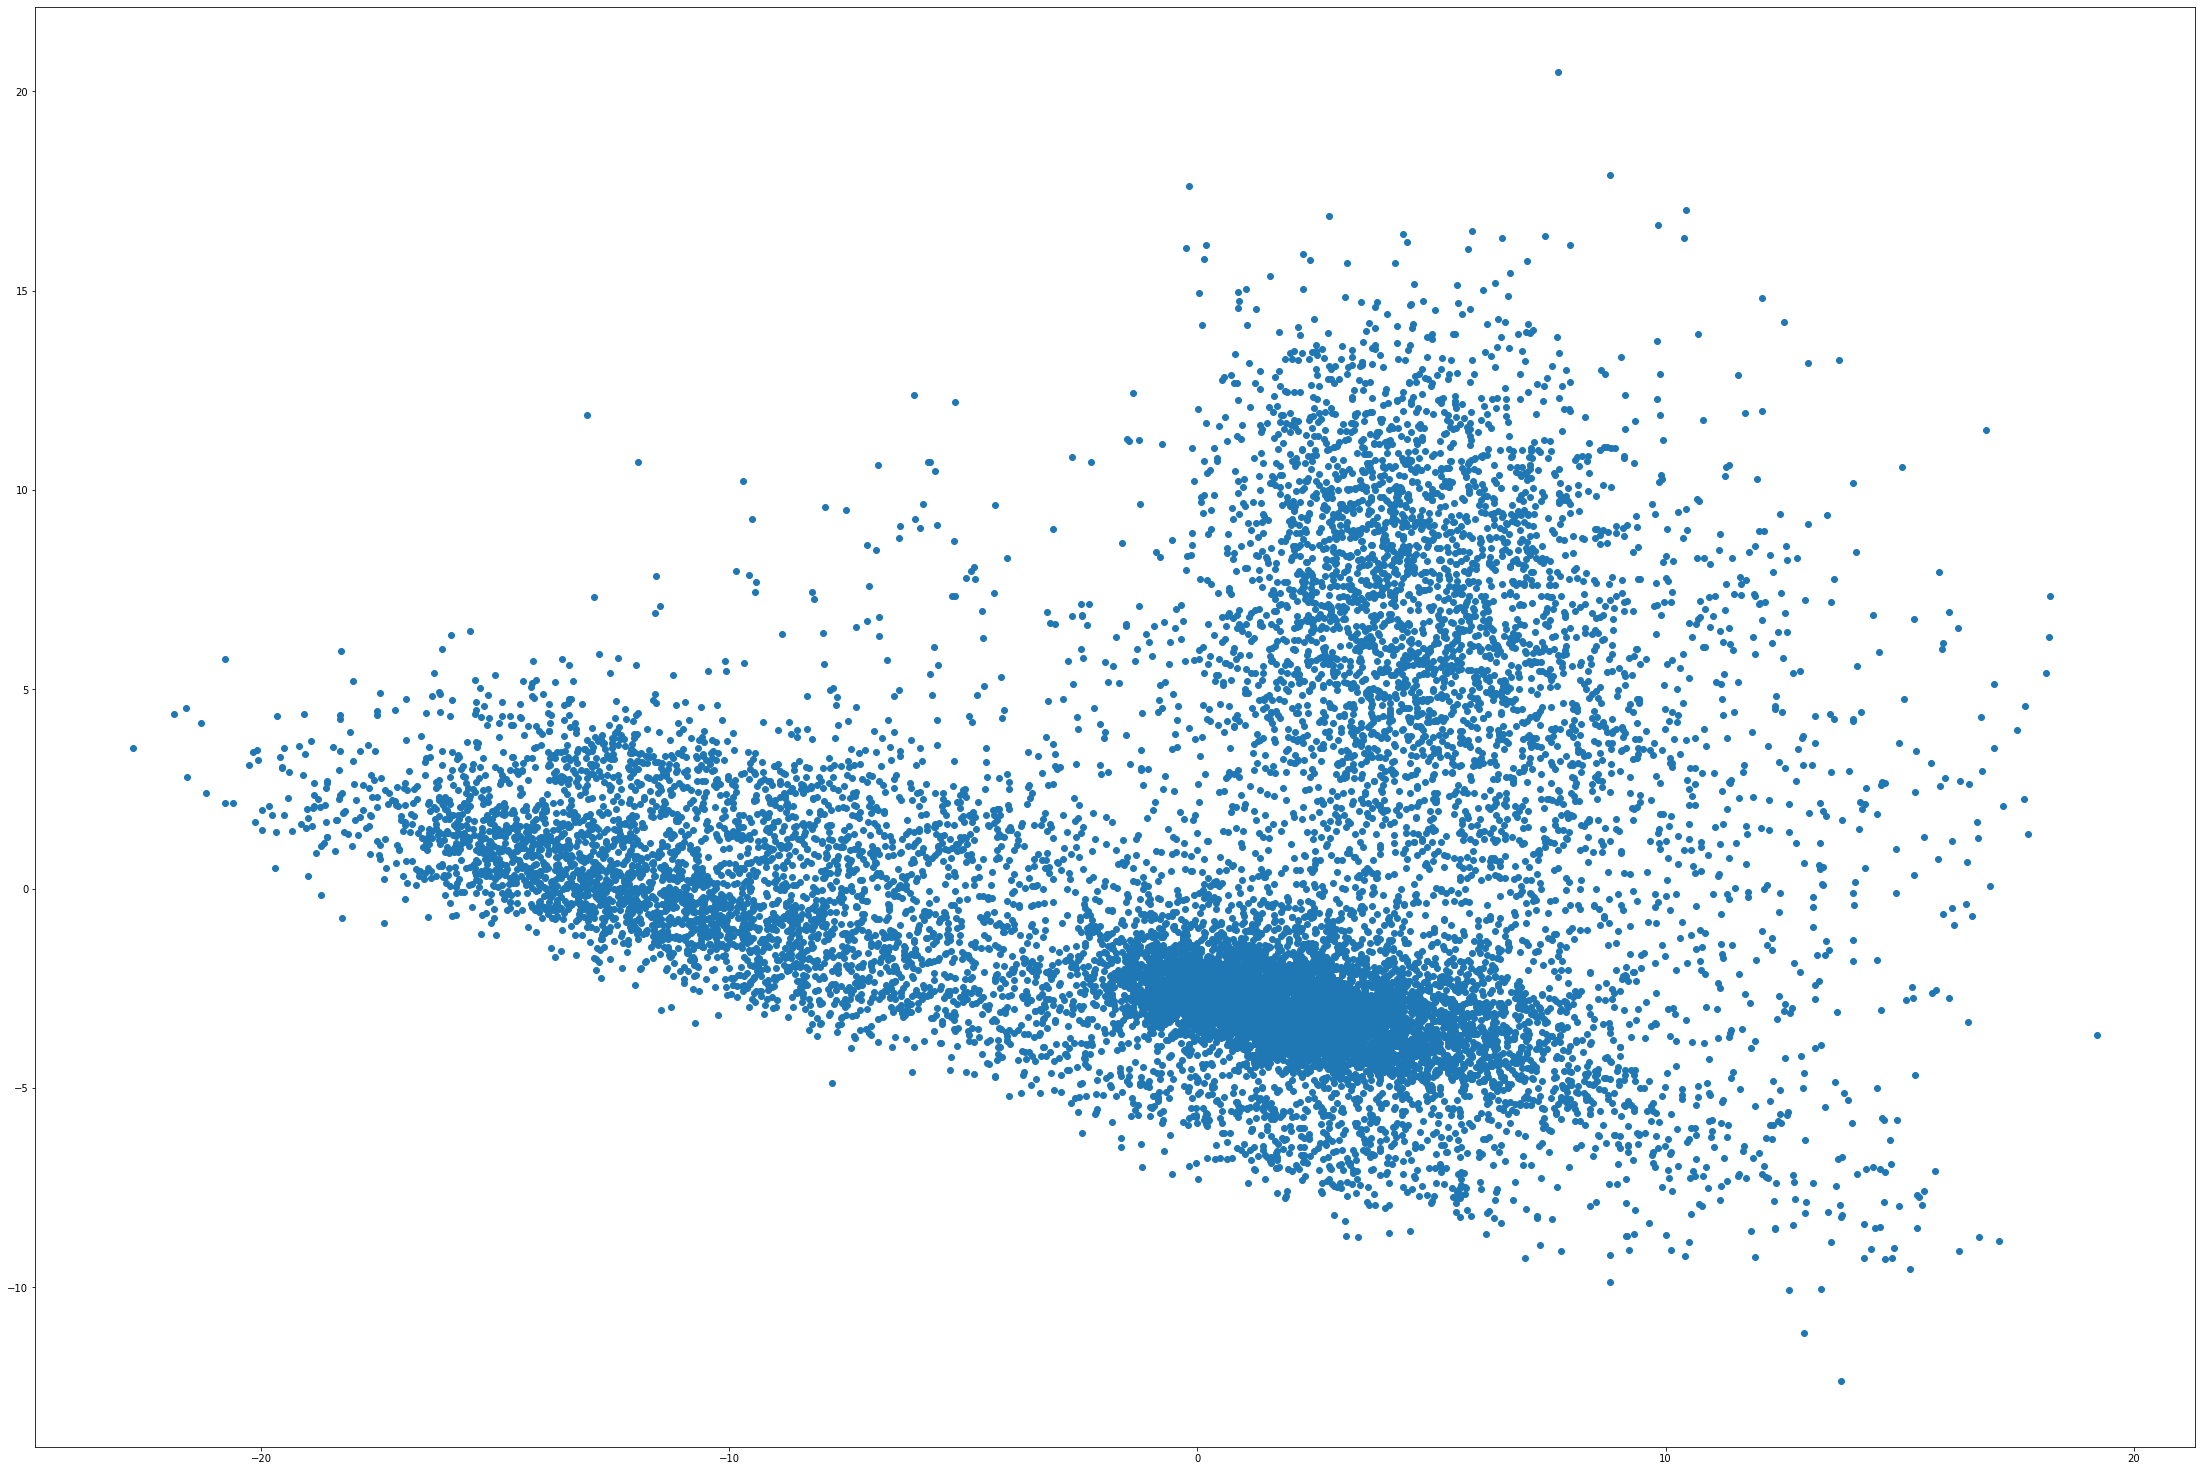

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure().add_axes([-5, -5, 5, 5])
fig.scatter(pd_df["PC1"], pd_df["PC2"])
plt.show()

We can also plot the categories of the cells.

In [33]:
label_df = pd.read_csv("datasets/PBMC_16k_RNA_label.csv")
pd_df = pd.merge(pd_df, label_df, how='inner', left_on='index', right_on='index')
original_df = pd.merge(df, label_df, how='inner', left_on='index', right_on='index')

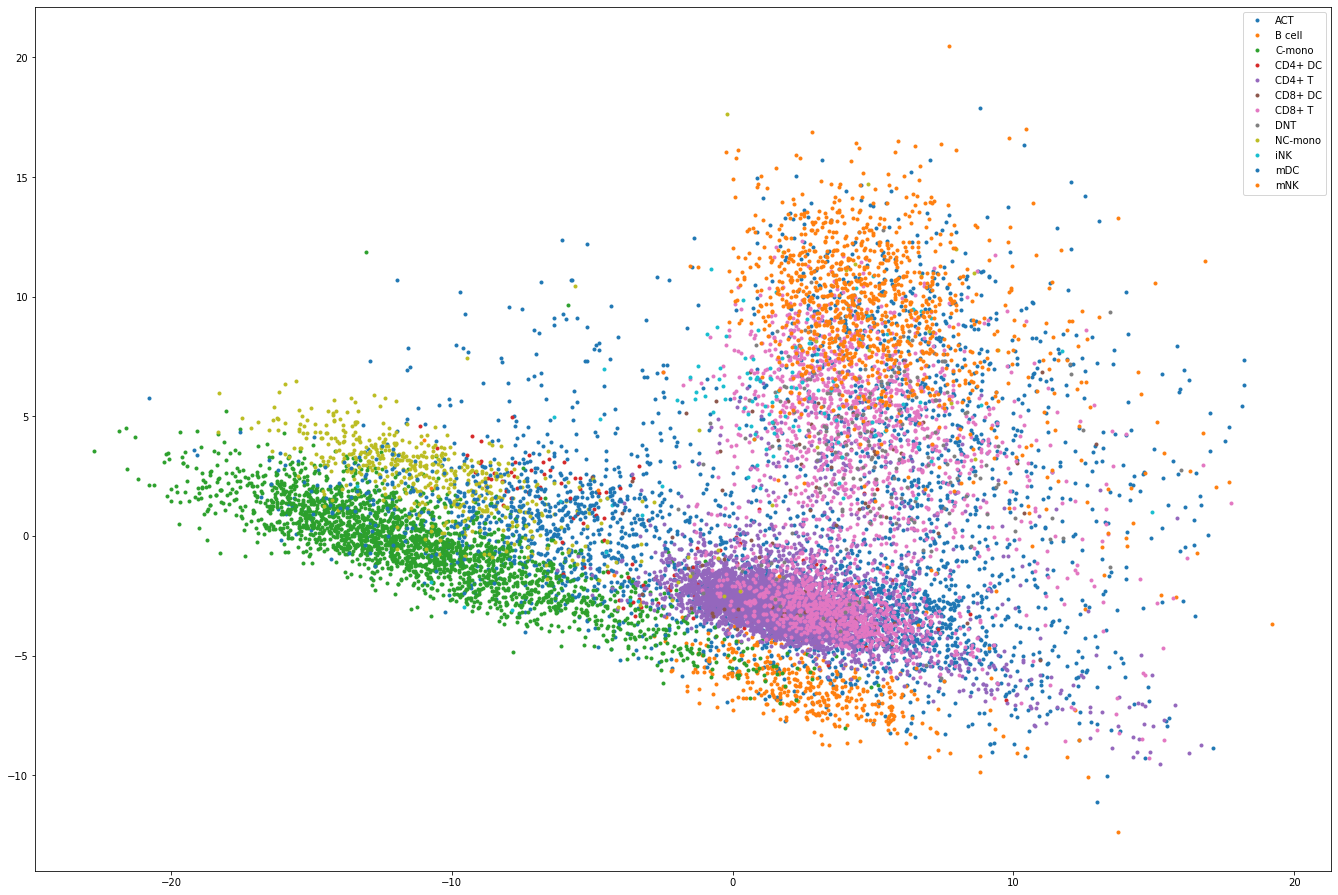

In [32]:
import seaborn as sns

groups = pd_df.groupby('CITEsort')

# Plot
fig = plt.figure().add_axes([-3, -3, 3, 3])
for name, group in groups:
    fig.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=3, label=name)
fig.legend()

plt.show()

We can see that the same type of cell are clearly clustered together, meaning that their principal components are close to each other. In contrast, selecting two random columns as our x- and y-axis will give the following plot,

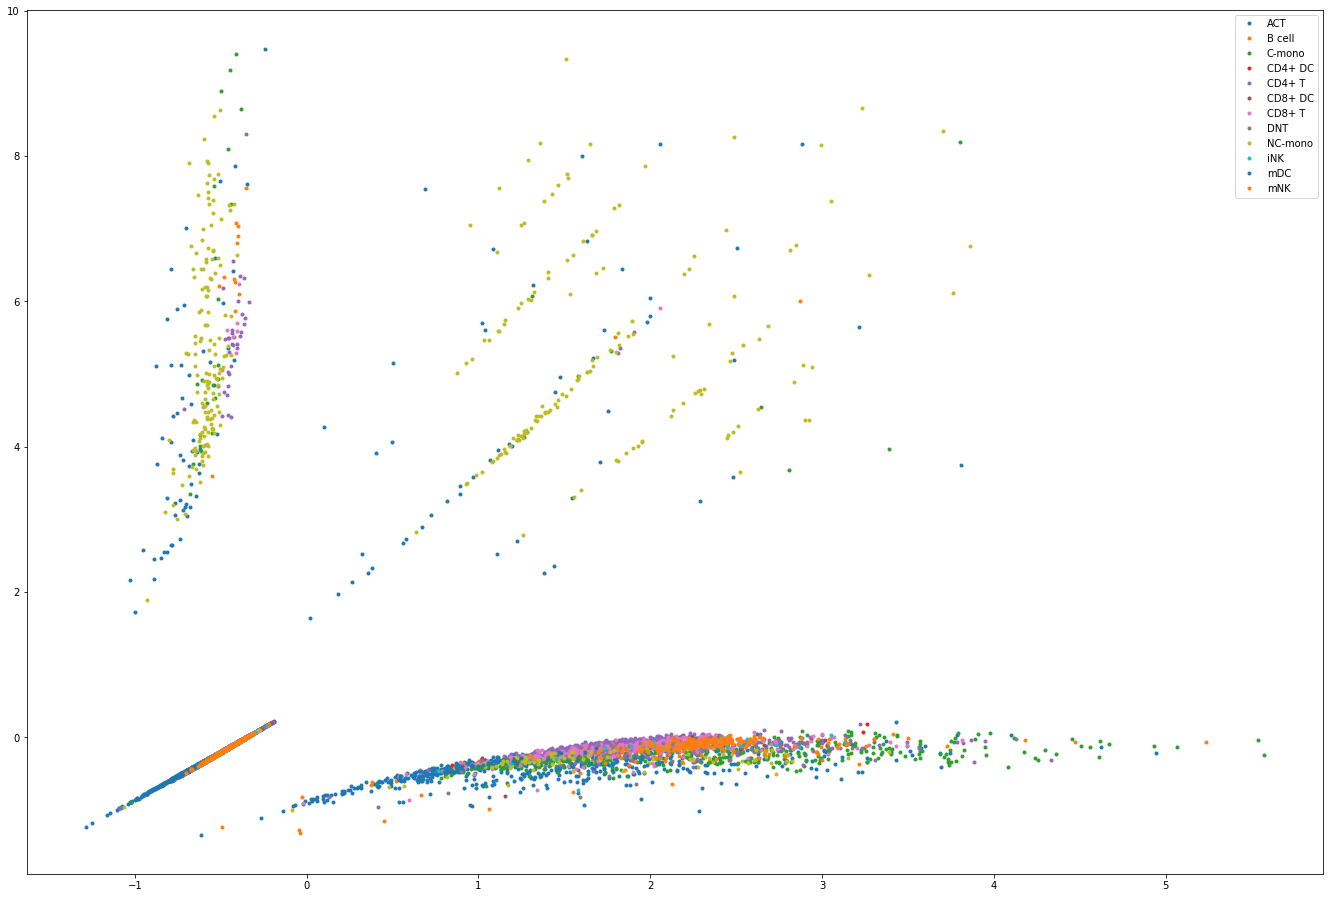

In [35]:
groups = original_df.groupby('CITEsort')

# Plot
fig = plt.figure().add_axes([-3, -3, 3, 3])
for name, group in groups:
    fig.plot(group.ISG15, group.HES4, marker='o', linestyle='', ms=3, label=name)
fig.legend()

plt.show()

where the same type of cell may not be in the same cluster. This shows that PCA is good at visualizing data of high dimension.

## Categorization Using Gradient Descent

We now try to do predictions: given the amount of mRNA a cell produces, predict the type of cell. We can do this using logistic regression. To simplify the case, we split the data into two categories

- B cell
- non-B cell


First we split the dataset into B cells and non-B cells.

In [37]:
data_df = spark.createDataFrame(pd_df)

In [38]:
data_df.show(5)

+------------------+------------------+-------------------+----------+----------+
|             index|               PC1|                PC2|CITEsort_x|CITEsort_y|
+------------------+------------------+-------------------+----------+----------+
|AAGGTTCTCAGTTTGG-1| 7.551907247933567|-3.7017827519266726|       ACT|       ACT|
|CGGACGTAGAAACGCC-1|-4.677808182321832| -3.708899792324685|    C-mono|    C-mono|
|GGCTCGATCCTAAGTG-1| 2.594065230906385|-2.8914118197042673|    CD4+ T|    CD4+ T|
|TACACGACAATAGCGG-1| 5.654800169108584| -2.954814475956951|    CD4+ T|    CD4+ T|
|TCAATCTCATTCGACA-1| 4.889871456252183|-2.8688424397376613|    CD8+ T|    CD8+ T|
+------------------+------------------+-------------------+----------+----------+
only showing top 5 rows



Again we can merge the principal components into a feature vector.

In [44]:
feature_assembler = VectorAssembler(inputCols=['PC1', 'PC2'], outputCol='features')
feature_df = feature_assembler.transform(data_df).select('index', 'features', 'CITEsort_x')
feature_df.show(5)

+------------------+--------------------+----------+
|             index|            features|CITEsort_x|
+------------------+--------------------+----------+
|AAGGTTCTCAGTTTGG-1|[7.55190724793356...|       ACT|
|CGGACGTAGAAACGCC-1|[-4.6778081823218...|    C-mono|
|GGCTCGATCCTAAGTG-1|[2.59406523090638...|    CD4+ T|
|TACACGACAATAGCGG-1|[5.65480016910858...|    CD4+ T|
|TCAATCTCATTCGACA-1|[4.88987145625218...|    CD8+ T|
+------------------+--------------------+----------+
only showing top 5 rows



And we can divide the dataframe into two: those B cells and non-B cells.

In [73]:
feature_df.createOrReplaceTempView("data")

b_cell_df = spark.sql("SELECT features FROM data WHERE CITEsort_x == 'B cell'")
non_b_cell_df = spark.sql("SELECT features FROM data WHERE CITEsort_x != 'B cell'")
b_cell_df.show(5)

+--------------------+
|            features|
+--------------------+
|[3.07302901439331...|
|[5.97497916224374...|
|[2.18758193059538...|
|[1.57666597748795...|
|[2.62942253619096...|
+--------------------+
only showing top 5 rows



We can then turn them into spark RDD and use `mllib.regression` and `mllib.classification` libraries.

In [78]:
from pyspark.mllib.regression import LabeledPoint

b_cell_rdd = b_cell_df.rdd.map(lambda x: LabeledPoint(1, [x[0]]))
non_b_cell_rdd = non_b_cell_df.rdd.map(lambda x: LabeledPoint(1, [x[0]]))

b_cell_rdd.take(5)

[LabeledPoint(1.0, [3.073029014393318,-6.907028191552955]),
 LabeledPoint(1.0, [5.9749791622437405,-5.747257055774806]),
 LabeledPoint(1.0, [2.1875819305953823,-5.350230429226559]),
 LabeledPoint(1.0, [1.5766659774879594,-5.370675129111073]),
 LabeledPoint(1.0, [2.6294225361909667,-7.571549793685464])]

We split the data into 2 parts: 70% as training set and 30% as test set.

In [79]:
data = b_cell_rdd.union(non_b_cell_rdd)
(training_data, test_data) = data.randomSplit([0.7, 0.3])

We can use `LogisticRegressionWithSGD` to train our model.

In [101]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

training_data.cache()
model = LogisticRegressionWithSGD.train(training_data, iterations=100, step=0.001)
labels_and_predictions = test_data.map(lambda x: (x.label, model.predict(x.features)))
error_rate = labels_and_predictions.filter(lambda res: res[0] != res[1]).count() / float(test_data.count())

print("Error Rate: " + str(error_rate))



Error Rate: 0.35736062717770034


The resulting error rate is a bit too large, maybe due to the small number of principal components. I can add more parameters later to see how it behaves.